**Predicting Subscription Habits based on Age and Played Hours in a Minecraft Server**

Samantha Cham, Daha Choi, Trini Laughlen, and Madeline Miles

**Introduction**

**Methods**

In [1]:
#load libraries needed
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

#set the seed to make the process reproducible
set.seed(2025)

#read in data
players<-read_csv('https://raw.githubusercontent.com/madeline1312/toy_ds_project/refs/heads/main/players.csv')|>
mutate(subscribe=as_factor(subscribe))|>#made as a factor so we can build our classification model
select(Age, played_hours, subscribe)|># We can see NA's in the data, so we have to remove them to bind_cols later
drop_na()
players


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

Age,played_hours,subscribe
<dbl>,<dbl>,<fct>
9,30.3,TRUE
17,3.8,TRUE
17,0.0,FALSE
⋮,⋮,⋮
22,0.3,FALSE
17,0.0,FALSE
17,2.3,FALSE


In [2]:
#find the summary statistics of what we are looking at so we know what our scales are for the predictors
players_stats<-players|>
mutate(mean_age=mean(Age,na.rm=TRUE))|>
mutate(min_age=min(Age,na.rm=TRUE))|>
mutate(max_age=max(Age, na.rm=TRUE))|>
mutate(min_played_hours=min(played_hours))|>
mutate(max_played_hours=max(played_hours))|>
mutate(mean_played_hours=mean(played_hours))|> 
select(mean_age, min_age, max_age, min_played_hours, max_played_hours, mean_played_hours)|> 
slice(1)
players_stats


mean_age,min_age,max_age,min_played_hours,max_played_hours,mean_played_hours
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
20.52062,8,50,0,223.1,5.904639


In our analysis in finding a summary of the data set that is needed for our analysis we found that the minimum age of a player is 8 the max age is 50 and the mean age is 20.5. This shows that since we have such a variety of ages and a large age range we have to center and scale our data in order for the model to be accurate when making predictions.
The analysis found that the minmimum number of players hours is 0, while the max is 223.1 hours and the average is 5.9 hours. This tells us that since the range is so wide we have to center and scale our data so that it is given the same weight as the age of the player, when used to predict the subscribtion habits of a player. 

Warning message in scale_x_log10():
“log-10 transformation introduced infinite values.”


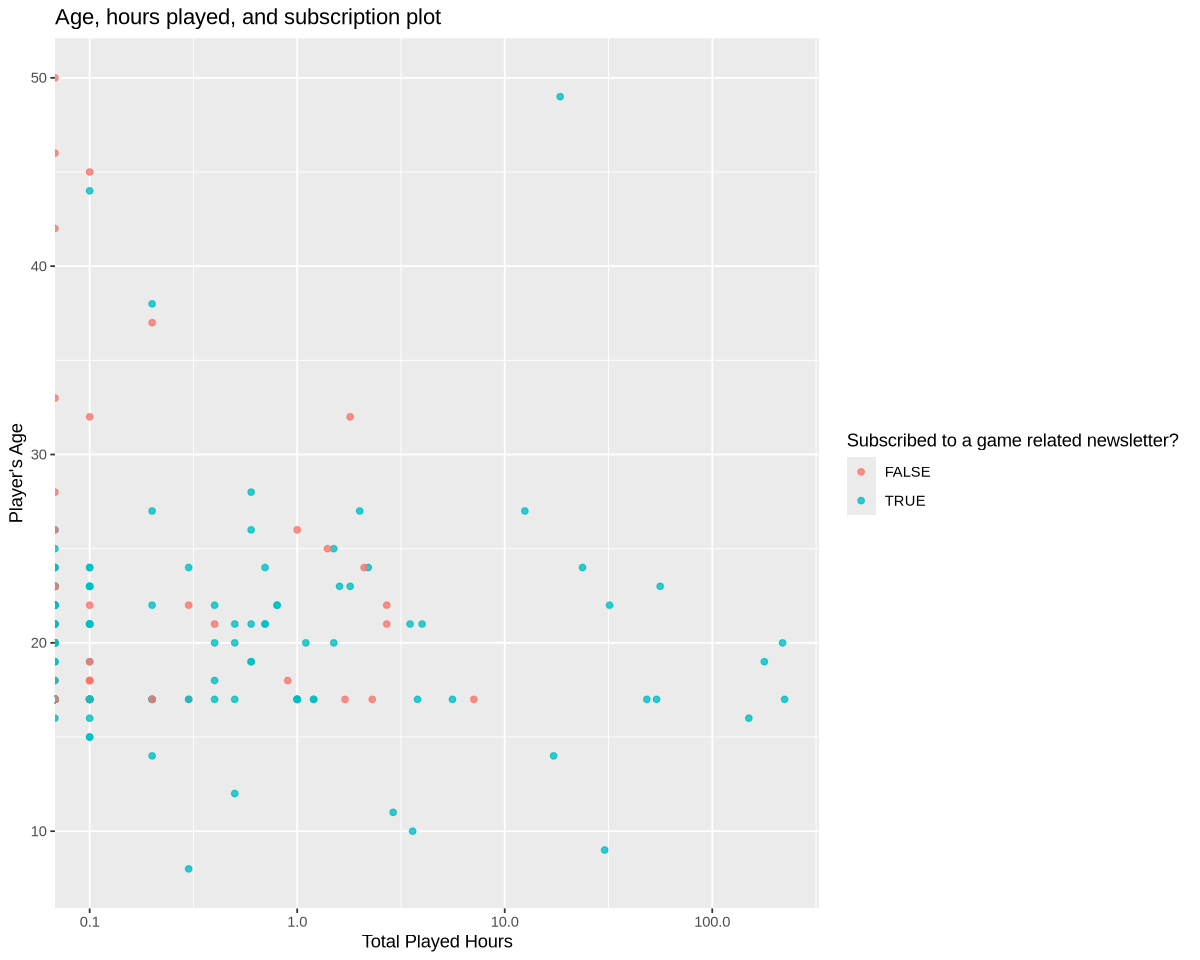

In [3]:
options(repr.plot.width = 10, repr.plot.height = 8) 
players_plot<-players|>
ggplot(aes(x=played_hours, y=Age, colour=subscribe))+
geom_point(alpha=0.8)+
labs(y="Player's Age", x="Total Played Hours", 
     colour="Subscribed to a game related newsletter?")+
ggtitle("Age, hours played, and subscription plot")+
scale_x_log10()

players_plot


This plot shows all three variables that we are considering together, and there appears to be no direct correlation between the amount of hours played on the server along with the players age to their subscrbtion habits to a game related newsletter. It can be seen that many of the played hours come from the younger players around our mean age, and that the players who are subscribed to a game-related newsletter often have more playing hours than the ones who aren't subscribed to a game related newsletter. 

We should look at each predcitor we will use to see if their is a correlation and find what we can expect the outcome to be from there. 

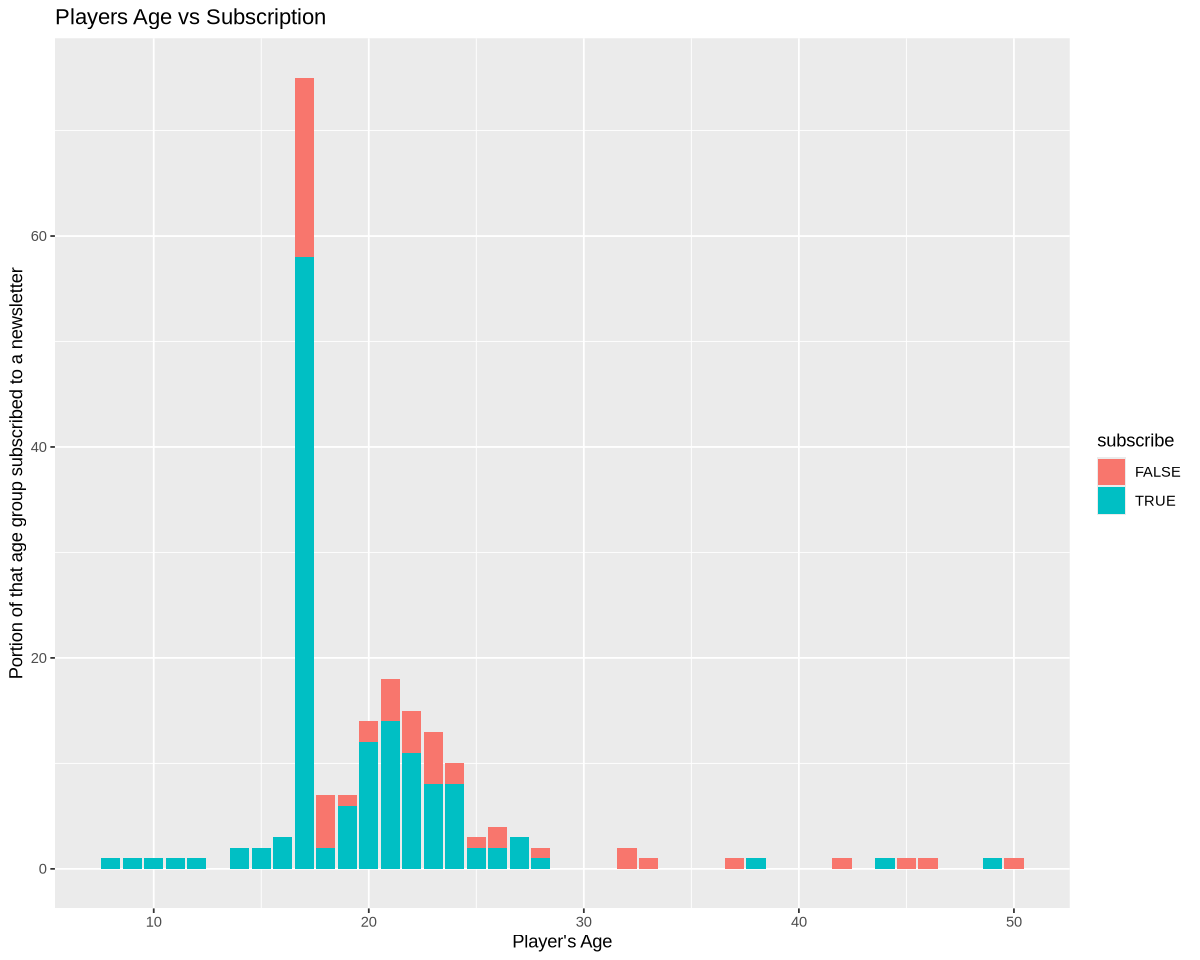

In [4]:
Age_plot<-players|>
ggplot(aes(x=Age, fill=subscribe))+
geom_bar()+
labs(x="Player's Age", y="Portion of that age group subscribed to a newsletter", 
     colour="Subscribed to a game related newsletter?")+
ggtitle("Players Age vs Subscription")
Age_plot


This plot shows the players age vs their subscribtion habits to a game related newsletter. We can see a trend here that the younger a player is the more likely they are to subscribe to a game related newsletter, but there are a few outliers in this graph as well. 

Warning message in scale_x_log10():
“log-10 transformation introduced infinite values.”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 85 rows containing non-finite outside the scale range (`stat_bin()`).”


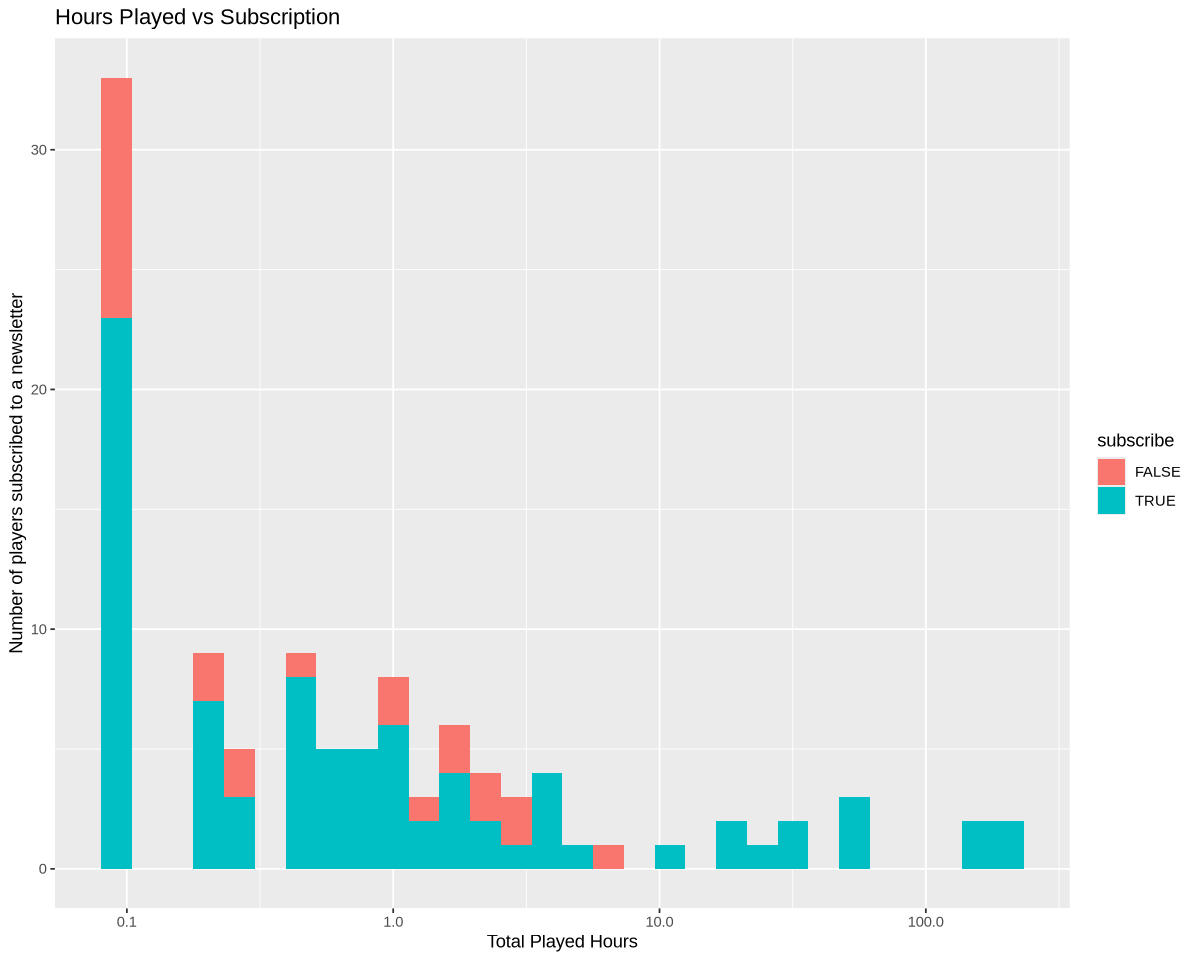

In [5]:
#This plot shows hours played vs Subsription
played_plot<-players|>
ggplot(aes(x=played_hours, fill=subscribe))+
geom_histogram()+
labs(y="Number of players subscribed to a newsletter", x="Total Played Hours", 
     colour="Subscribed to a game related newsletter?")+
ggtitle("Hours Played vs Subscription")+
scale_x_log10()
played_plot


This plot shows that the more hours you play the more likely you are to subscribe to a game related newsletter, but there isn't a clear trend on the relationships between the number of hours played on the server and if the player is subscribed to a game related newsletter. 

When building our model and later testing it, we do expect that the model is pretty accurate but not very accurate as their is a clear trend with the age of the player and if they are subscribed to a game-related newsletter, but not as strong of a relationship between the hours played and subscrbtion habits. Because one of the two relationships isn't extremly clear through visaulizations, we expect the model to be accurate as there is a clear relationship between one predictor and the outcome but not as clear between the second predictor and the outcome. 

In [6]:
#Now we will build out model
#Let's seperate the data into training and testing data sets
players_split<-players|>
initial_split(prop=0.6, strata=subscribe)
players_train<-training(players_split)
players_test<-testing(players_split)

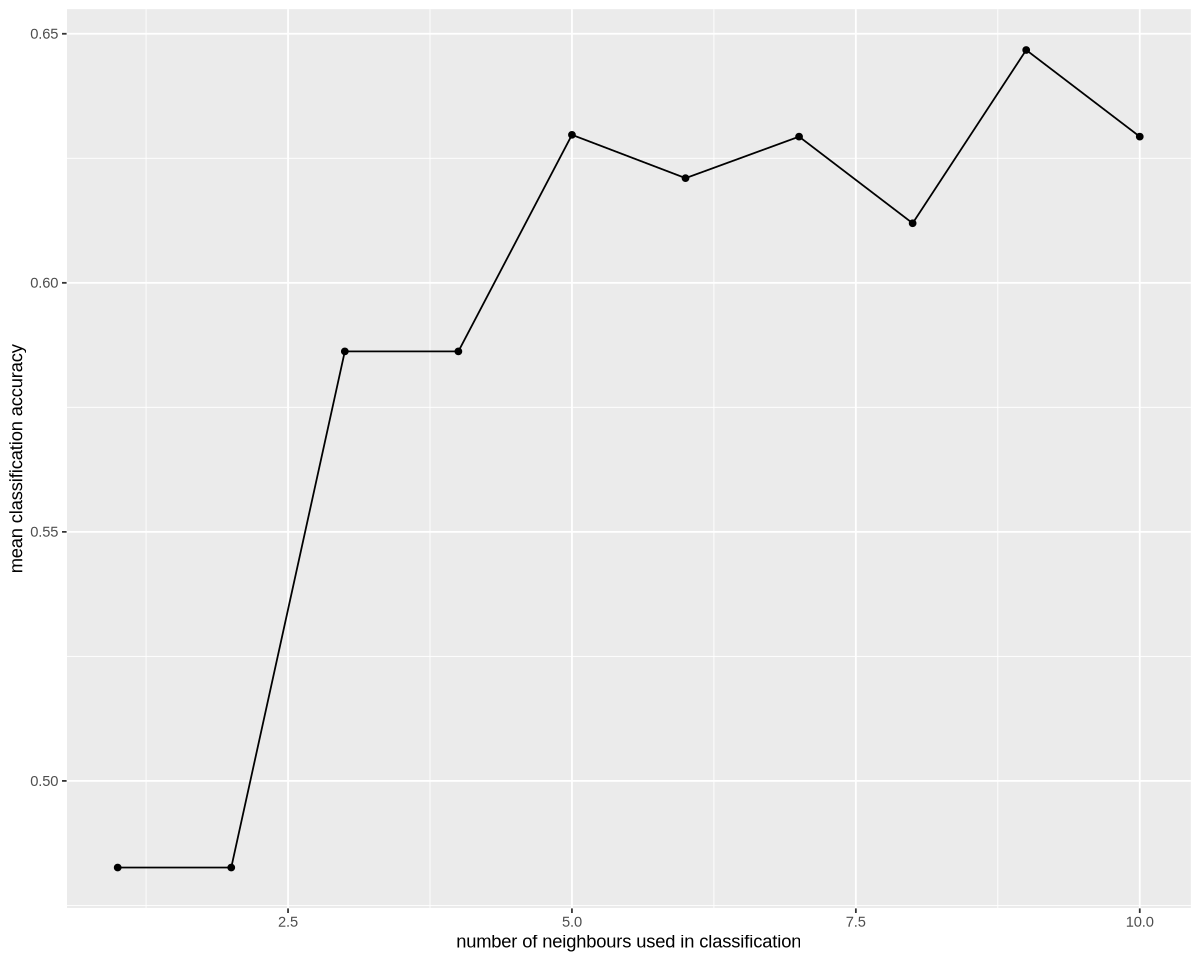

In [7]:
set.seed(2025)
#Build the model, initally use tune until the best k value is found. 
knn_tune<-nearest_neighbor(weight_func='rectangular',neighbors=tune())|>
set_engine('kknn')|>
set_mode('classification')

players_recipe<-recipe(subscribe~Age+played_hours, data=players_train)|>
step_center(all_predictors())|>
step_scale(all_predictors())

workflow<-workflow()|>
add_recipe(players_recipe)|>
add_model(knn_tune)

players_vfold<-vfold_cv(players_train, v=5, strata=subscribe)

players_table<-tibble(neighbors=seq(from=1, to=10, by=1))

knn_results<-workflow|>
tune_grid(resample=players_vfold, grid=players_table)|>
collect_metrics()|>
filter(.metric=='accuracy')

cross_val_plot<-knn_results|>
ggplot(aes(y=mean, x=neighbors))+
geom_point()+
geom_line()+
labs(y="mean classification accuracy", x="number of neighbours used in classification")
cross_val_plot

This plot shows that with the testing data only the highest accuracy knn that we get from the cross-validation with 5 folds is 9, with an accuracy of just under 65%, this is good for the training set, and now we rebuild our model with a neighbors value of k=9.

In [12]:
set.seed(2025)
#build the model with k=9 to have the best accuracy
players_knn<-nearest_neighbor(weight_func='rectangular', neighbors=9)|>
set_mode('classification')|>
set_engine('kknn')

players_workflow<-workflow()|>
add_recipe(players_recipe)|>
add_model(players_knn)|>
fit(data=players_train)


**Results**

In [11]:
players_results<-players_workflow|>
predict(players_test)|> 
bind_cols(players_test)
players_results


.pred_class,Age,played_hours,subscribe
<fct>,<dbl>,<dbl>,<fct>
TRUE,9,30.3,TRUE
TRUE,19,0.0,TRUE
TRUE,21,0.0,FALSE
⋮,⋮,⋮,⋮
FALSE,17,0.0,TRUE
FALSE,17,0.0,FALSE
TRUE,22,0.3,FALSE


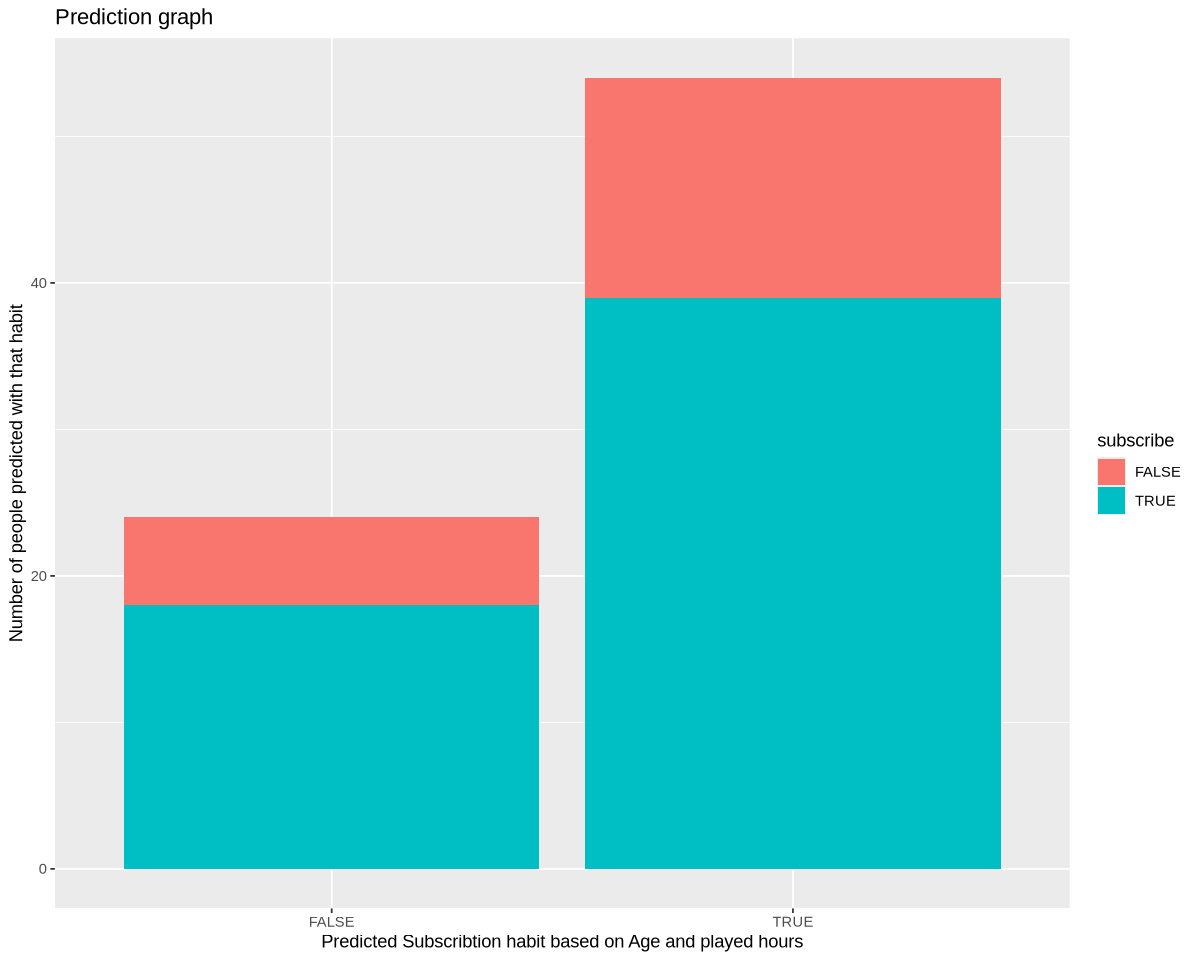

In [9]:
players_results_plot<-players_results|>
ggplot(aes(x=.pred_class, fill=subscribe))+
geom_bar()+
xlab("Predicted Subscribtion habit based on Age and played hours")+
ylab("Number of people predicted with that habit")+
ggtitle("Prediction graph")
players_results_plot


This plot shows that the model predicted a person to subscribe to a newsletter more often than a person not subscribing to a newsletter, and while that prediction was accurate for many people it over predicted this value. When predicting that a person wouldn't subscribe to a game-related newsletter, the model predicted that the player wouldn't when most of the time they would, only a small number of predictions that were "FALSE" were in reality actually "FALSE". 

In [10]:
set.seed(2025)
#test the model to see if it is accurate with the testing data
knn_accuracy<-players_results|>
metrics(truth=subscribe, estimate=.pred_class)|>
filter(.metric=="accuracy")|>
pull()

knn_accuracy


[1] 0.5769231

The accuracy of our model is 57.69%. This demonstrates that there is a slight correlation between the number of hours played and the age of player in relation to if they are subscribed to a game related newsletter, but their isn't a strong relationship between the two predictors and what we were predicting. 

**Discussion**

Hi